In [307]:
%matplotlib inline
import json
import sys
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import zscore
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import decomposition
from sklearn import datasets
from sklearn.decomposition import PCA

## Adatok beolvasása

In [308]:
data = pd.read_csv('input_data/census2000.csv')

In [309]:
#földrajzi jellegű változók eldobása
data = data.drop(['ID'], axis =1)
data = data.drop(['LocX'], axis =1)
data = data.drop(['LocY'], axis =1)
data = data.drop(['RegPop'], axis =1)

In [310]:
data.head(1)

,RegDens,MedHHInc,MeanHHSz
0,70,9888,3.24


### Hisztogramok

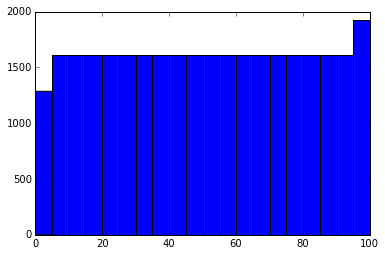

In [311]:
histogram = plt.hist(data.RegDens, range=[0,100], bins=20)

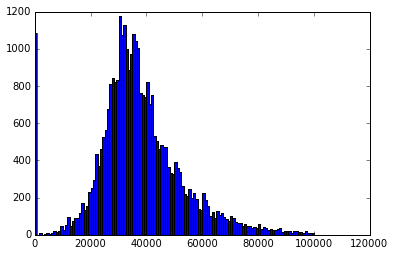

In [312]:
histogram = plt.hist(data.MedHHInc, range=[0,100000], bins=120)

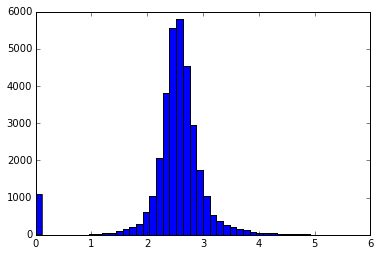

In [313]:
histogram = plt.hist(data.MeanHHSz, range=[0,6], bins=50)

Látható, hogy sok helyen 0 érték van megadva. Ezek a sorok nincsenek sokan, de a ''MeanHHSz'' és a ''MedHHInc'' esetén zavarják az elemzést, ezért ezeket a sorokat eldobjuk.

In [314]:
data = data[data.MedHHInc != 0] #azon sorok törlése, ahol nincs megadva medhhinc
data = data[data.MeanHHSz != 0] #azon sorok törlése, ahol nincs megadva MeanHHSz
print("Ennyi sor maradt: ")
data.count(axis=0)[0]

Ennyi sor maradt: 


32096

## Változók létrehozása

In [315]:
medhhinc_array = data['MedHHInc'].values
medhhinc_mean = medhhinc_array.mean() #átlag
medhhinc_std = medhhinc_array.std() #szórás
maxval = medhhinc_mean + 3*medhhinc_std #maximum érték
print(maxval)

88325.0405877


In [316]:
data = data[data.MedHHInc < maxval] #max felettiek eldobása
data.count(axis=0)[0]

31581

In [317]:
#változók létrehozása
data['IncomePerCapita'] = data.apply(lambda row: row['MedHHInc'] / row['MeanHHSz'], axis = 1 )
data.head(3)

,RegDens,MedHHInc,MeanHHSz,IncomePerCapita
0,70,9888,3.24,3051.851852
1,83,11384,3.10,3672.258065
2,86,10748,2.84,3784.507042


In [318]:
data = data[data.MeanHHSz > 1] #eldobjuk azokat a régiókat, ahol egy háztartásban, 1-nél kevesebben élnek (kb. 10 darab)

In [319]:
data.MedHHInc = np.log(data.MedHHInc) #logaritmikus transzformáció
data.head(3)

,RegDens,MedHHInc,MeanHHSz,IncomePerCapita
0,70,9.199077,3.24,3051.851852
1,83,9.339964,3.10,3672.258065
2,86,9.282475,2.84,3784.507042


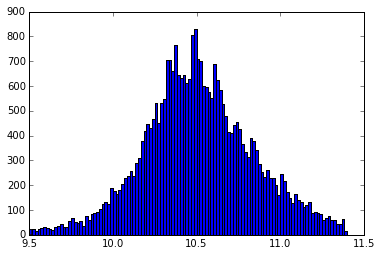

In [320]:
histogram = plt.hist(data.MedHHInc, bins=120, range=[9.5,11.5]) #hisztogramja

### Z-normalizálás

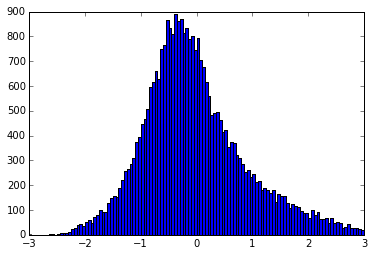

In [321]:
data["IncomePerCapita"] = zscore(data["IncomePerCapita"])
data["RegDens"] = zscore(data["RegDens"])
data["MedHHInc"] = zscore(data["MedHHInc"])
data["MeanHHSz"] = zscore(data["MeanHHSz"])
histogram = plt.hist(data.IncomePerCapita, bins=120, range=[-3,3])

In [322]:
data.head(3)

,RegDens,MedHHInc,MeanHHSz,IncomePerCapita
0,0.694473,-3.651838,1.722236,-2.242224
1,1.146310,-3.255130,1.355178,-2.126309
2,1.250580,-3.417007,0.673498,-2.105337


# Klaszterezés

## Hierarchikus

In [323]:
#a végrehajtás túl hosszú, ezért a tesztek idejére az adathalmazt elvágjuk
dm = data #adatok másolása
dm = dm.iloc[np.random.permutation(len(data))] #shuffle
dm = dm[0:18000] #vágás
#a tapasztalatok szerint 5000 minta -> 1 perc, és kb. exponenciálisan nő.
#5000->1perc
#6500->2perc
#8000->3,5perc
#13000-> 15perc
#18000-> 40perc
#sajnos több ma nem fér az időbe valószínűleg, ezért 18k méretű mintával csinálom az elemzést. 
#a teljes 31k méretű minta előreláthatólag több órát venne igénybe.
dm.head(3)

,RegDens,MedHHInc,MeanHHSz,IncomePerCapita
22074,-0.834820,0.163524,0.568625,-0.254560
13629,-0.070173,-0.997787,-0.113055,-0.945673
10250,1.424363,0.190427,-1.450195,0.749534


In [324]:
#%timeit -n 1 -r 1 -o ward = AgglomerativeClustering(n_clusters=3, linkage='ward').fit_predict(dm) #időmérés

In [325]:
ward = AgglomerativeClustering(n_clusters=3, linkage='ward').fit_predict(dm) #hierarchikus klaszterező ráhúzása

In [326]:
import warnings
warnings.filterwarnings('ignore') #a következő sorban valami nem tetszik neki és nagy warningot dobna
dm.loc[:,'Group']  = ward #a klaszterezés eredménye a táblázatban
dm.Group.mean() #de itt a bizonyíték, hogy működik azért :D

0.42905555555555558

### Plot

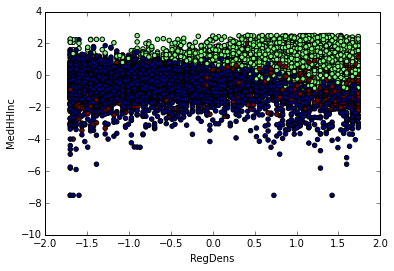

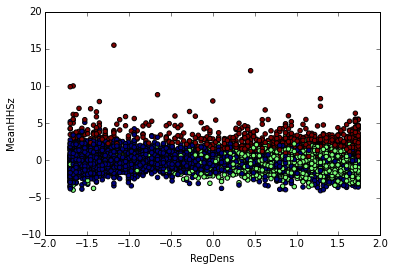

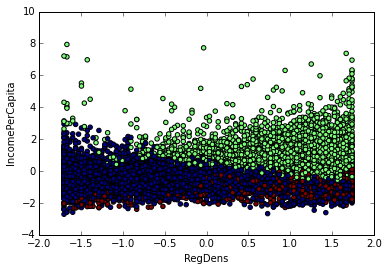

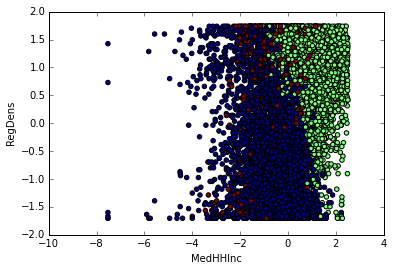

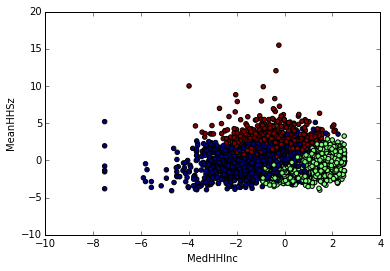

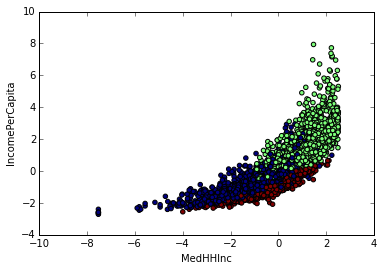

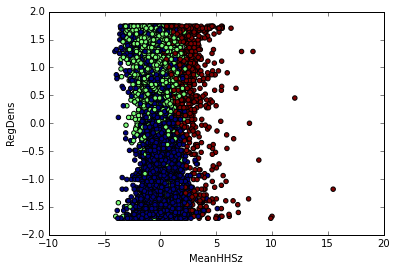

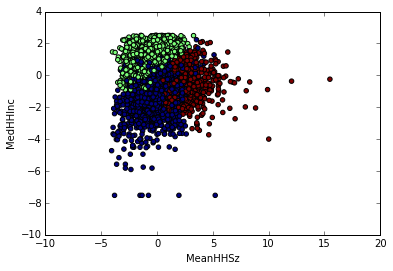

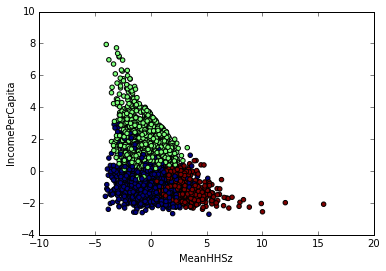

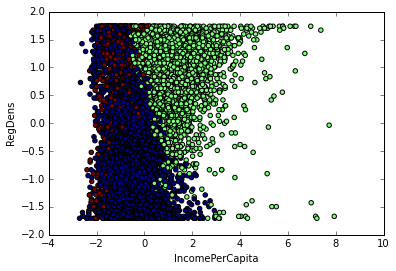

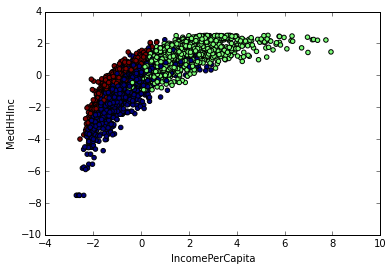

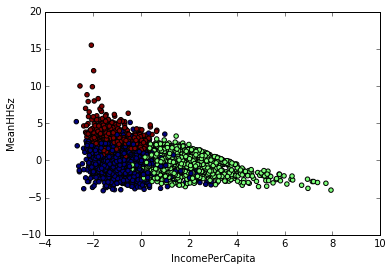

In [327]:
for i in range(0,4):
    for j in range(0,4):
        if (i!=j):
            plt.scatter(dm[dm.columns[i]], dm[dm.columns[j]], c=dm.Group)
            plt.xlabel(dm.columns[i])
            plt.ylabel(dm.columns[j])
            plt.show()

Ebből látni lehet, hogy a legtöbb 2D-s szeletet tekintve, a csoportok jól elkülönülnek. Ez egy 3D-s ábrában is látható alul:

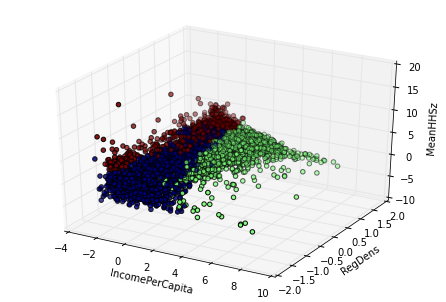

In [328]:
import mpl_toolkits.mplot3d.axes3d as p3
fig = plt.figure()
ax = p3.Axes3D(fig)
#ax.view_init(-6, 6)

ax.scatter(dm.IncomePerCapita, dm.RegDens, dm.MeanHHSz, c=dm.Group)
ax.set_zlabel('MeanHHSz')
ax.set_ylabel('RegDens')
ax.set_xlabel('IncomePerCapita')
plt.show()

### PCA

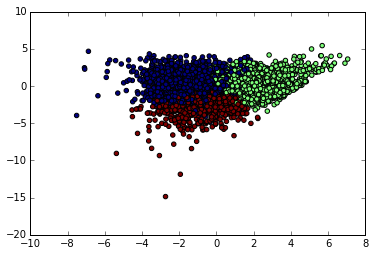

In [329]:
pca = PCA(n_components=2)
dmtrans = pca.fit_transform(dm.drop(['Group'], axis=1))
plt.scatter(dmtrans[:,0],dmtrans[:,1], c=dm.Group)
plt.show()

Nem sokkal jobban, szerintem a szeletekből, vagy a 3D-s ábrából több látszik. 

### Elemzés klaszterközéppontok segítségével

In [330]:
for i in range(0,3):
    dsz = dm[dm.Group == i]
    print(i)
    print(dsz.mean())

0
RegDens           -0.506905
MedHHInc          -0.415888
MeanHHSz          -0.141367
IncomePerCapita   -0.410665
Group              0.000000
dtype: float64
1
RegDens            0.889344
MedHHInc           0.927264
MeanHHSz          -0.155691
IncomePerCapita    1.046991
Group              1.000000
dtype: float64
2
RegDens            0.828401
MedHHInc          -0.218478
MeanHHSz           2.150901
IncomePerCapita   -0.843308
Group              2.000000
dtype: float64


1. csoport (kék): Gyéren lakott vidéken laknak, viszonylag szegények, de átlagos méretűek a háztartások.

2. csoport (zöld): A legsűrűbb területeken, valószínűleg városokban laknak. Átlagos méretű háztartásokban élnek, nagyon sok pénzből.

3. csoport (piros): Alapból nem sok pénz folyik be egy háztartásba, de mivel sokan is vannak, ezért egy főre nagyon kevés jut. Nagyrészt ők is sűrűn lakott régiókban élnek.

A particionáló algoritmushoz nem találtam a scikit-ben megfelelő függvényt, de ha az meglenne, mindent pontosan ugyanúgy csinálnék vele, mint fent. Az n_clusters paraméter meghatározása nehéz, órákon át olvastam az internetet a témában, de nem találtam olyan python függvényt, amely egyértelműen megmondaná a klaszterezés minőségét 2-nél több dimenziós adathalmazon. Ettől függetlenül próbálgatás alapján n_clusters=3 esetén néz ki jól.